In [1]:
!pip uninstall tensorflow
!pip install tensorflow==1.15.0
!pip install bert-tensorflow

^C


ERROR: Could not find a version that satisfies the requirement tensorflow==1.15.0 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0)
ERROR: No matching distribution found for tensorflow==1.15.0

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 64.4/64.4 kB 1.2 MB/s eta 0:00:00



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
MAX_TOKEN_LENGTH = 64
N_EPOCHS = 10
BATCH_SIZE = 1
LABEL_COLUMNS = ['label']

In [3]:
train_df = pd.read_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime.xlsx")
print(train_df.describe())
print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

                                                    Title  Label
count                                               16864  16864
unique                                              16330      2
top     FIFA takes on EA Sports video game in soccer’s...  Crime
freq                                                    4   8641
All entries unique: False
Null cells: 0


In [4]:
train_df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')
print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")

All entries unique: True


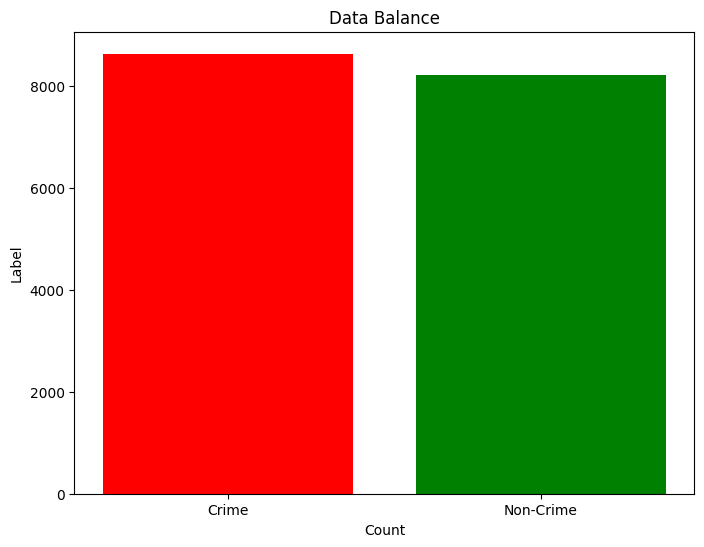

In [4]:
filtered_df = pd.DataFrame(columns=['text', 'label', 'word_count'])

for check_label in LABEL_COLUMNS:
    if check_label not in filtered_df.columns.tolist()[1:]:
        raise Exception("Label names in 'filtered_df' do not match with LABEL_COLUMNS. Check the label columns and add them to LABEL_COLUMNS")

filtered_df['label'] = (pd.Categorical(train_df['Label']).codes).astype(int)
label_counts = train_df['Label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Data Balance')
plt.show()

Average Word count: 11.996501423149905


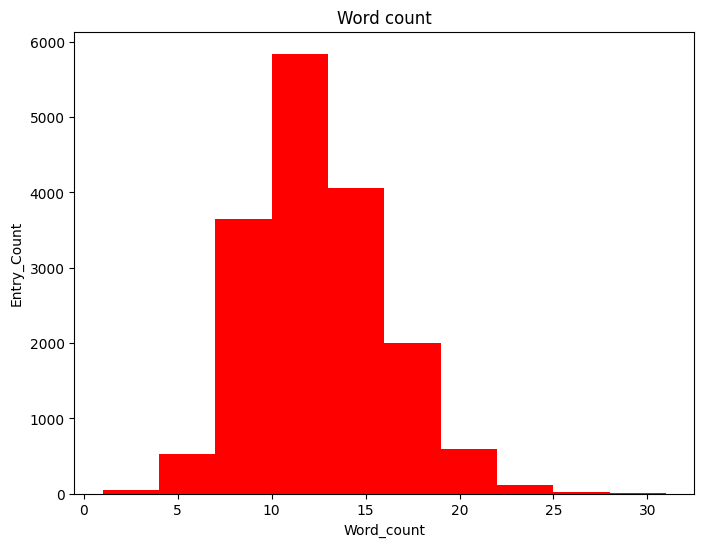

In [5]:
text_list = []
word_count = []

for entry in train_df['Title']:
    new_text = re.sub("[^a-zA-Z ]", " ", entry)
    new_text = new_text.lower().split()
    word_count.append(len(new_text))
    new_text = ' '.join(new_text)
    text_list.append(new_text)

filtered_df['text'] = text_list
filtered_df['word_count'] = word_count

plt.figure(figsize=(8, 6))
print(f'Average Word count: {np.average(word_count)}')
plt.hist(word_count,color='red')
plt.title('Word count')
plt.xlabel('Word_count')
plt.ylabel('Entry_Count')
plt.show()

In [47]:
train_dev_df = filtered_df.sample(n=200)
print(train_dev_df['label'].value_counts())
print(train_dev_df.head())

1    100
0    100
Name: label, dtype: int64
                                                    text  label  word_count
11752  rishi kapoor s last film sharmaji namkeen to r...      1          20
7733   from state police win union home minister s medal      0           9
9797   tamil nadu black flag protest will not comprom...      1          16
1042   woman fed liquor gangraped in front of yr old ...      0          14
7083   army recruitment exam cancelled after paper le...      0          11


In [36]:
test_df = filtered_df.sample(n=100)
print(test_df['label'].value_counts())
print(test_df.head())

0    53
1    47
Name: label, dtype: int64
                                                    text  label  word_count
11116  doctor strange in the multiverse of madness ba...      1          12
1268    yr old youth shot dead in amritsar s baba bakala      0          10
3077   in e crime crackdown gujarat police link cops ...      0          10
14082  poco m pro g might feature dimensity chip mah ...      1          10
5991   upsc cse key february what you need to read today      0          10


In [54]:
df_bert = pd.DataFrame({
    'id' :range(len(train_dev_df)),
    'label': train_dev_df['label'],
    'alpha': ['a']*train_dev_df.shape[0],
    'text': train_dev_df['text']
})

df_bert_train, df_bert_dev = train_test_split(df_bert, test_size=0.25)

df_bert_train.head()

,id,label,alpha,text
4737,20,0,a,sharjeel imam held in bihar set to be brought ...
2197,99,0,a,another case filed under new triple talaq law ...
14468,91,1,a,lock upp anjali arora opens up about her bond ...
16396,150,1,a,rejection of savarkar resolution devendra fadn...
9093,130,1,a,the man behind samsung cameras explains how ga...


In [53]:
df_bert_test = pd.DataFrame({
    'id' :range(len(test_df)),
    'text': test_df['text']
})

df_bert_test.reset_index(inplace=True, drop=True)
df_bert_test.head()

,id,text
0,0,doctor strange in the multiverse of madness ba...
1,1,yr old youth shot dead in amritsar s baba bakala
2,2,in e crime crackdown gujarat police link cops ...
3,3,poco m pro g might feature dimensity chip mah ...
4,4,upsc cse key february what you need to read today


In [64]:
os.makedirs('./bert_data/', exist_ok=True)
df_bert_train.to_csv('bert_data/train.tsv', sep='\t', index=False, header=False)
df_bert_dev.to_csv('bert_data/dev.tsv', sep='\t', index=False, header=False)
df_bert_test.to_csv('bert_data/test.tsv', sep='\t', index=False, header=False)